## Medical image data - BoneMRI


In [24]:
# Library imports
import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np
import os
import napari

from image_utils import *
from scipy.ndimage import label
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.decomposition import PCA
from scipy.spatial.transform import Rotation as R

dicom_path = os.path.join("boneMRI", "20240304_BoneMRI_EBS26")
segmentation_path = os.path.join("boneMRI", "20240304_BoneMRI_EBS26_Segmentation.nii")

## Loading the data

The shape of the image is (100, 672, 672)


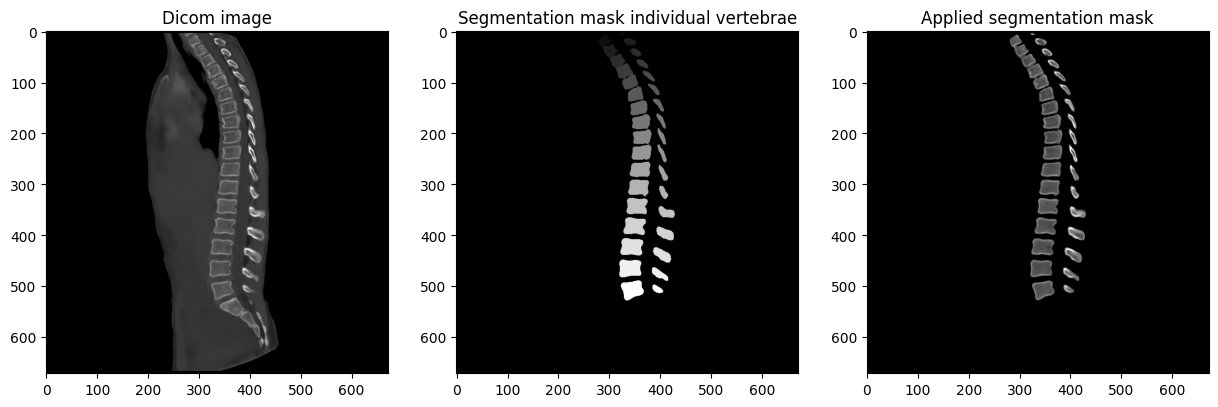

In [25]:
# Load segmentation data
segment = sitk.ReadImage(segmentation_path)
segment_data = sitk.GetArrayFromImage(segment)
segment_all = segment_data > 0

# Load dicom data and apply windowing
dicom_image = load_3d_dicom(dicom_path)
dicom_image = apply_window(dicom_image, window_level=450, window_width=1500)
segment_dicom_image = dicom_image*segment_all
print(f"The shape of the image is {dicom_image.shape}")

# Plot data 
slice_index = 50  # Middle slice along the z-axis
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(dicom_image[slice_index, :, :], cmap='gray')
ax[0].set_title("Dicom image")
ax[1].imshow(segment_data[slice_index, :, :], cmap='gray')
ax[1].set_title("Segmentation mask individual vertebrae")
ax[2].imshow(segment_dicom_image[slice_index, :, :], cmap='gray')
ax[2].set_title("Applied segmentation mask");

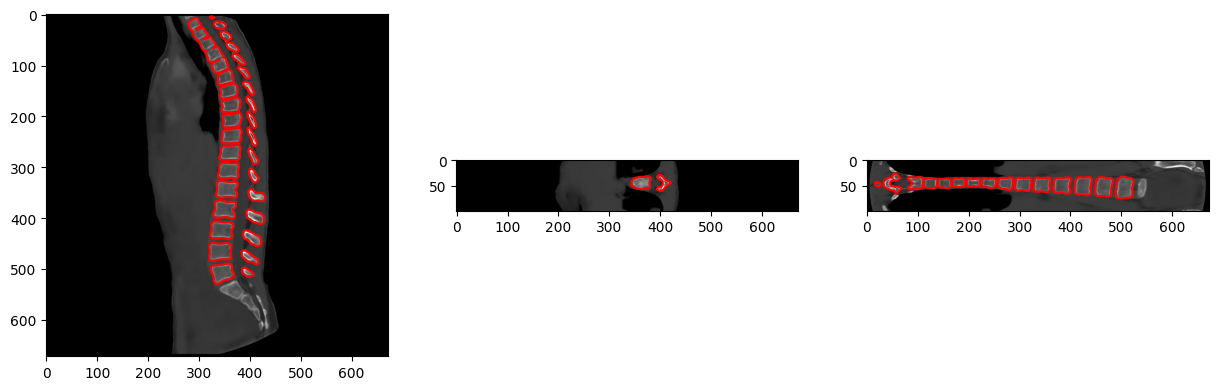

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(dicom_image[50, :, :], cmap='gray')
ax[0].contour(segment_data[50, :, :], levels=[0.5], colors='r', linewidths=1.5)
ax[1].imshow(dicom_image[:, 250, :], cmap='gray')
ax[1].contour(segment_data[:, 250, :], levels=[0.5], colors='r', linewidths=1.5)
ax[2].imshow(dicom_image[:, :, 350], cmap='gray')
ax[2].contour(segment_data[:, :, 350], levels=[0.5], colors='r', linewidths=1.5)

## Generate radiographs/compressions from 3D CT data

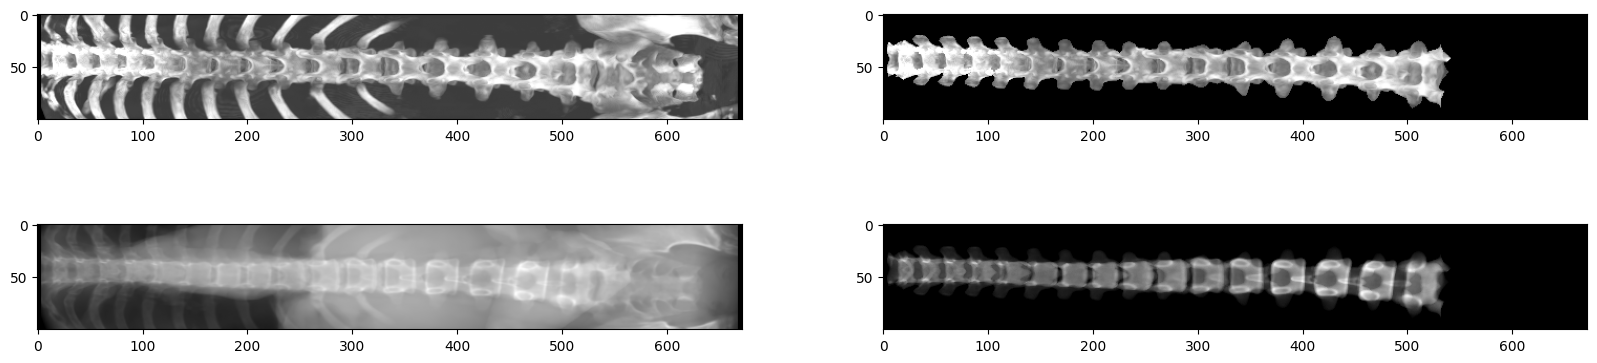

In [3]:
# Create a radiograph from CT
radiograph = get_radiograph(dicom_image, axis=0)
segment_radiograph = get_radiograph(segment_dicom_image, axis=0)
compressed = compress_bonemri(dicom_image, axis=2)
segment_compressed = compress_bonemri(segment_dicom_image, axis=2)

fig, ax = plt.subplots(2, 2, figsize=(20, 5))
ax = ax.flatten()
ax[0].imshow(radiograph, cmap="gray")
ax[1].imshow(segment_radiograph, cmap="gray")
ax[2].imshow(compressed, cmap="gray")
ax[3].imshow(segment_compressed, cmap="gray");

## Image rotation

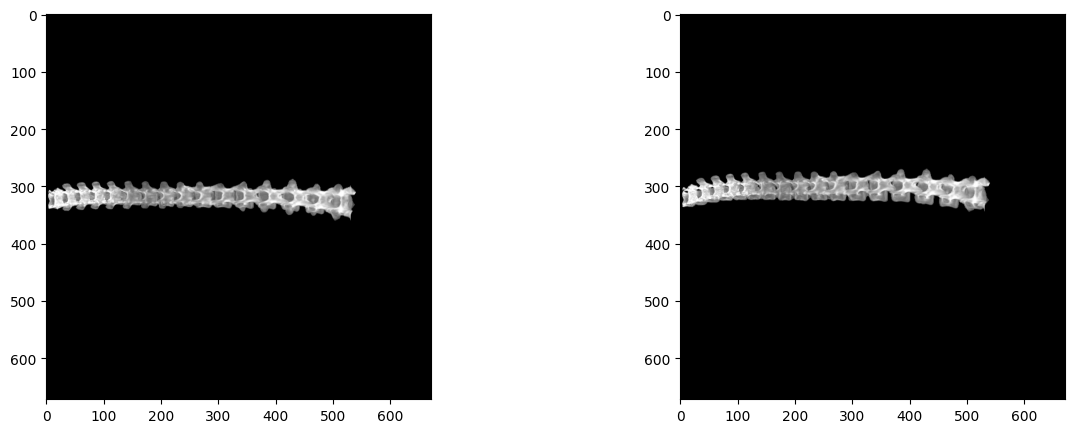

In [4]:
# Rotate full images
rotated_spine_10 = rotate_image(segment_dicom_image, axis=1, angle=10)
rotated_spine_20 = rotate_image(segment_dicom_image, axis=1, angle=20)

# Compress images
compressed_rotated_spine_10 = get_radiograph(rotated_spine_10, axis=0)
compressed_rotated_spine_20 = get_radiograph(rotated_spine_20, axis=0)

# Plot data
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(compressed_rotated_spine_10, cmap='gray')
ax[1].imshow(compressed_rotated_spine_20, cmap='gray');

## Bounding cubes - Individual vertebrae

In [5]:
# Obtain unique labels for the vertebrae (skipping zero)
vertebrae_labels = np.unique(segment_data)[1:]

# Find bounding cube coordinates for each vertebrae
bounding_cubes_mask = {}
bounding_cubes_coord = {}
for label in vertebrae_labels:
    # Get indices for individual vertebrae
    indices_vertebra = np.where(segment_data == label)

    # Get minimum and maximum coordinates in all three dimensions
    x_min, x_max = np.min(indices_vertebra[2]), np.max(indices_vertebra[2])
    y_min, y_max = np.min(indices_vertebra[1]), np.max(indices_vertebra[1])
    z_min, z_max = np.min(indices_vertebra[0]), np.max(indices_vertebra[0])

    # Store bounding cube coordinates
    bounding_cubes_coord[int(label)] = {
        "x_min": int(x_min), "x_max": int(x_max),
        "y_min": int(y_min), "y_max": int(y_max),
        "z_min": int(z_min), "z_max": int(z_max)
    }

    # Create and store bounding cube
    bcube = np.zeros_like(segment_data, dtype=int)
    bcube[z_min:z_max, y_min:y_max, x_min:x_max] = 1
    bounding_cubes_mask[label] = bcube

viewer = napari.Viewer()
viewer.add_image(segment_dicom_image, name="Segmented CT")
for label, bcube in bounding_cubes_mask.items():
    viewer.add_labels(bcube, name=f"Bounding cube {label}")
viewer.dims.ndisplay = 3
napari.run()

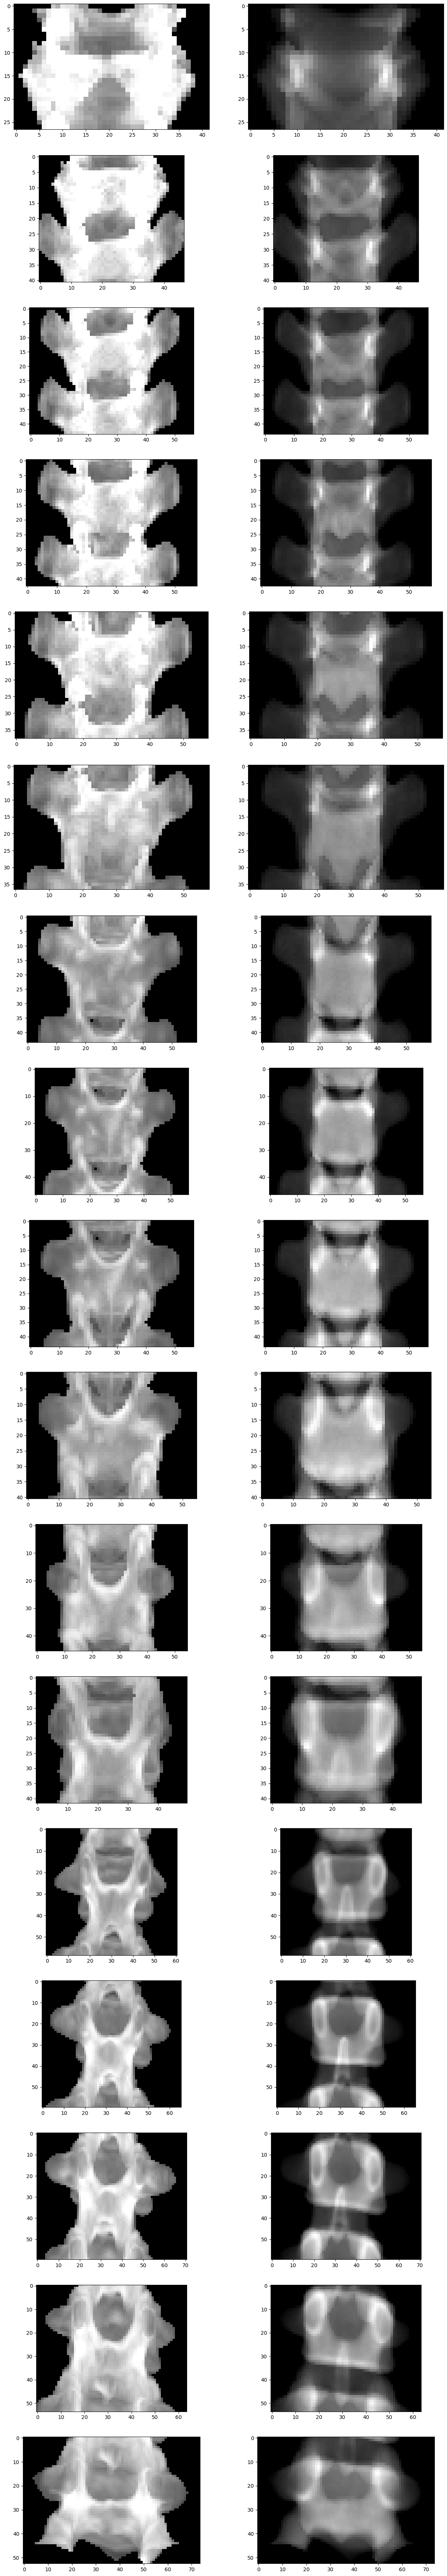

In [6]:
# Plot for individual vertebrae bounding cubes
fig, ax = plt.subplots(17,2,figsize=(15,90))

for idx, label in enumerate(vertebrae_labels):
    # Obtain individual vertebra bcube mask
    bcube_coord = bounding_cubes_coord[label]
    bcube_vertebra = segment_dicom_image[
        bcube_coord["z_min"]-5:bcube_coord["z_max"]+5,
        bcube_coord["y_min"]:bcube_coord["y_max"],
        bcube_coord["x_min"]:bcube_coord["x_max"],
    ]
    # Plot radiograph
    bcube_radiograph = get_radiograph(bcube_vertebra, axis=0)
    ax[idx,0].imshow(np.rot90(bcube_radiograph, 3), cmap="gray")
    # Plot compressed image
    bcube_compressed = compress_bonemri(bcube_vertebra, axis=2)
    ax[idx,1].imshow(np.rot90(bcube_compressed, 3), cmap="gray")


## Oriented Bounding Box and Angles - Individual bounding cubes

In [7]:
# Function to get Oriented Bounding Box
def compute_obb(binary_volume):
    """
    Compute the oriented bounding box (OBB) and its rotation angles.
    
    Parameters:
        binary_volume (numpy.ndarray): A 3D binary volume.

    Returns:
        obb_corners (numpy.ndarray): 8 corners of the oriented bounding box.
        rotation_matrix (numpy.ndarray): 3x3 rotation matrix.
        euler_angles (tuple): (yaw, pitch, roll) in degrees.
    """
    coords = np.argwhere(binary_volume)  # Get voxel coordinates

    # Compute PCA
    pca = PCA(n_components=3)
    pca.fit(coords)
    components = pca.components_

    # Ensure Y-axis is correctly oriented (fix flipped axis issue)
    if np.linalg.det(components) < 0:
        components[1, :] *= -1  # Flip second principal component if needed

    # Center the coordinates before PCA
    centered_coords = coords - coords.mean(axis=0)

    # Project into PCA space
    rotated_coords = centered_coords @ components.T

    # Find min and max bounds in rotated space
    min_corner = rotated_coords.min(axis=0)
    max_corner = rotated_coords.max(axis=0)

    # Create bounding box corners in PCA space
    corners = np.array([
        [min_corner[0], min_corner[1], min_corner[2]],
        [min_corner[0], min_corner[1], max_corner[2]],
        [min_corner[0], max_corner[1], min_corner[2]],
        [min_corner[0], max_corner[1], max_corner[2]],
        [max_corner[0], min_corner[1], min_corner[2]],
        [max_corner[0], min_corner[1], max_corner[2]],
        [max_corner[0], max_corner[1], min_corner[2]],
        [max_corner[0], max_corner[1], max_corner[2]],
    ])

    # Transform bounding box back to original space correctly
    obb_corners = (corners @ components) + coords.mean(axis=0)

    # Round to integer voxel coordinates
    obb_corners = np.round(obb_corners).astype(int)

    # Extract rotation matrix
    R_matrix = components
    
    # Convert to Euler angles (XYZ order)
    euler_angles = R.from_matrix(R_matrix).as_euler('xyz', degrees=True)
    
    # Ensure angles are between -45 and 45 degrees
    euler_angles = np.array([(((a + 45)  % 90) - 45) for a in euler_angles])

    return obb_corners, centered_coords, R_matrix, euler_angles

# Visualize
def visualize_bounding_box(image_3d, obb_corners):
    """
    Visualize the oriented bounding box over the original 3D image.

    Parameters:
        image_3d (numpy.ndarray): A 3D image (grayscale or binary).
        obb_corners (numpy.ndarray): 8 corners of the bounding box.
    """
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    #Extract voxel positions where image intensity > 0
    coords = np.argwhere(image_3d > 0)
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c='gray', alpha=0.1, s=1)

    # Define edges of bounding box
    edges = [
        (0, 1), (0, 2), (0, 4), (1, 3), (1, 5), (2, 3),
        (2, 6), (3, 7), (4, 5), (4, 6), (5, 7), (6, 7)
    ]

    for edge in edges:
        p1, p2 = obb_corners[edge[0]], obb_corners[edge[1]]
        ax.plot(*zip(*[p1, p2]), color='r')
    
    # Get limits
    x_limits = [coords[:, 0].min(), coords[:, 0].max()]
    y_limits = [coords[:, 1].min(), coords[:, 1].max()]
    z_limits = [coords[:, 2].min(), coords[:, 2].max()]
    
    # Set equal scaling
    max_range = np.ptp(np.array([x_limits, y_limits, z_limits])).max() / 2.0
    mid_x = np.mean(x_limits)
    mid_y = np.mean(y_limits)
    mid_z = np.mean(z_limits)

    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    # Set labels
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.title("Oriented Bounding Box on 3D Image")

In [8]:
# Obtain unique labels for the vertebrae (skipping zero, assuming background is 0)
vertebrae_labels = np.unique(segment_data)
vertebrae_labels = vertebrae_labels[vertebrae_labels > 0]  # Exclude background (0)

# Store results for each vertebra
bounding_boxes = {}
rotation_matrices = {}
euler_angles_dict = {}
centeroids = {}

for label in vertebrae_labels:
    # Create a binary mask for the specific vertebra
    binary_volume = (segment_data == label).astype(np.uint8)

    # Compute the oriented bounding box (OBB)
    obb_corners, centeroid, rotation_matrix, euler_angles = compute_obb(binary_volume)

    # Store results
    bounding_boxes[label] = obb_corners
    centeroids[label] = centeroids
    rotation_matrices[label] = rotation_matrix
    euler_angles_dict[label] = euler_angles

print(f"Computed bounding box for {len(vertebrae_labels)} vertebra")

Computed bounding box for 17 vertebra


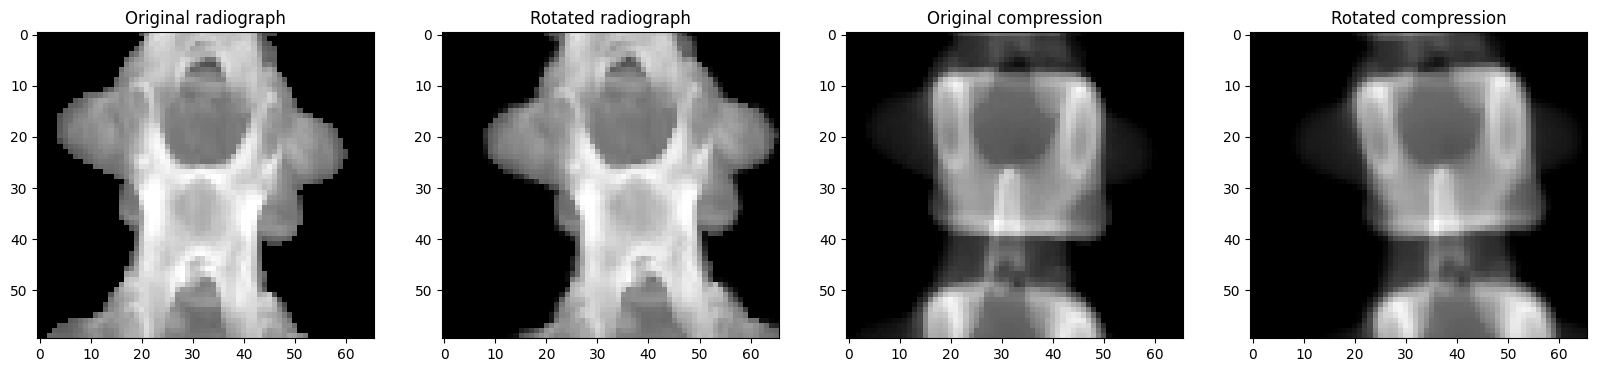

In [9]:
# Plot for individual vertebrae bounding cubes
fig, ax = plt.subplots(1,4,figsize=(20,5))

for idx, label in enumerate(vertebrae_labels[13:14]):
    # Obtain individual vertebra bcube mask
    bcube_coord = bounding_cubes_coord[label]
    bcube_vertebra = segment_dicom_image[
        bcube_coord["z_min"]-5:bcube_coord["z_max"]+5,
        bcube_coord["y_min"]:bcube_coord["y_max"],
        bcube_coord["x_min"]:bcube_coord["x_max"],
    ]
    # Define rotation angle
    angle = euler_angles_dict[label]

    # Calculate radiograph and compression images
    bcube_radiograph = get_radiograph(bcube_vertebra, axis=0)
    bcube_compressed = compress_bonemri(bcube_vertebra, axis=2)

    # Calculate rotated radiograph and compression images
    segment_dicom_image_rot = rotate_image(segment_dicom_image, axis=2, angle=-angle[2])
    #segment_dicom_image_rot = rotate_image(segment_dicom_image_rot, axis=1, angle=angle[1])
    segment_dicom_image_rot = segment_dicom_image_rot[285:385]
    bcube_vertebra_rot = segment_dicom_image_rot[
        bcube_coord["z_min"]-5:bcube_coord["z_max"]+5,
        bcube_coord["y_min"]:bcube_coord["y_max"],
        bcube_coord["x_min"]:bcube_coord["x_max"],
    ]
    bcube_radiograph_rot = get_radiograph(bcube_vertebra_rot, axis=0)
    bcube_compressed_rot = compress_bonemri(bcube_vertebra_rot, axis=2)

    # Plot images
    ax[0].imshow(np.rot90(bcube_radiograph, 3), cmap="gray")
    ax[0].set_title("Original radiograph")
    ax[1].imshow(np.rot90(bcube_radiograph_rot, 3), cmap="gray")
    ax[1].set_title("Rotated radiograph")
    ax[2].imshow(np.rot90(bcube_compressed, 3), cmap="gray")
    ax[2].set_title("Original compression")
    ax[3].imshow(np.rot90(bcube_compressed_rot, 3), cmap="gray")
    ax[3].set_title("Rotated compression")
    
